# Testing Augmentations

In [123]:
from bids_dataset import BidsDataModule, BidsDataset
import matplotlib.pyplot as plt
import numpy as np
import math
import monai
import os
import sys
from pathlib import Path
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    RandRotated,
    RandFlipd,
    RandAffined,
    CropForegroundd,
    Rand3DElasticd,
    RandAdjustContrastd,
    RandGaussianNoised,
)
from monai.transforms.spatial.functional import rotate
from monai.visualize import plot_2d_or_3d_image
import TPTBox
from TPTBox import NII

current_dir = os.getcwd()

file = Path(current_dir).resolve()
sys.path.append(str(file.parents[1]))
sys.path.append(str(file.parents[2]))

from utils import brats_tools

In [30]:
brats_path = "/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/train"
prefix = "BraTS-GLI-"
brats_data= BidsDataset(brats_path, binary = False, prefix = prefix)
test_idx = 2
test_dict = brats_data[test_idx]
img, mask = test_dict['img'], test_dict['seg']
print (img.shape, mask.shape)
brats_keys = ['img', 'seg']

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


## Testing Transformations

### Testing on pure Data taken from the Dataset

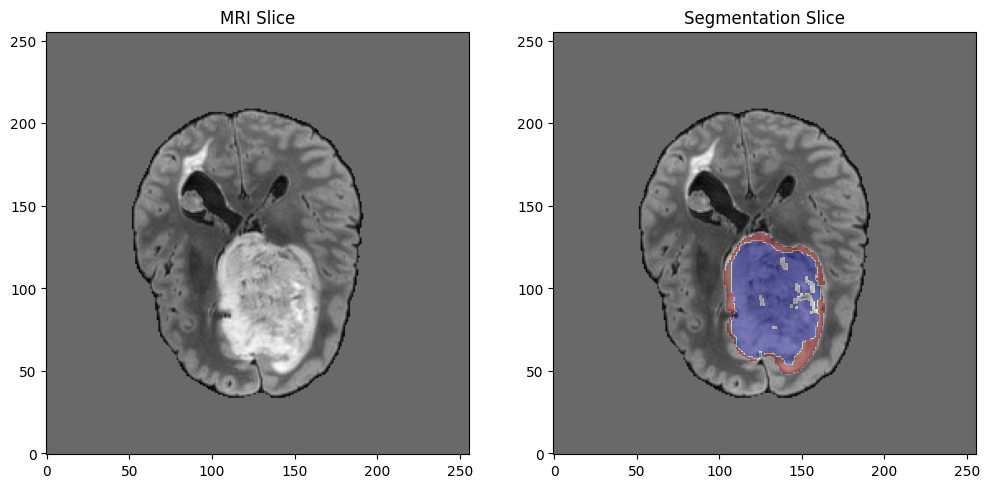

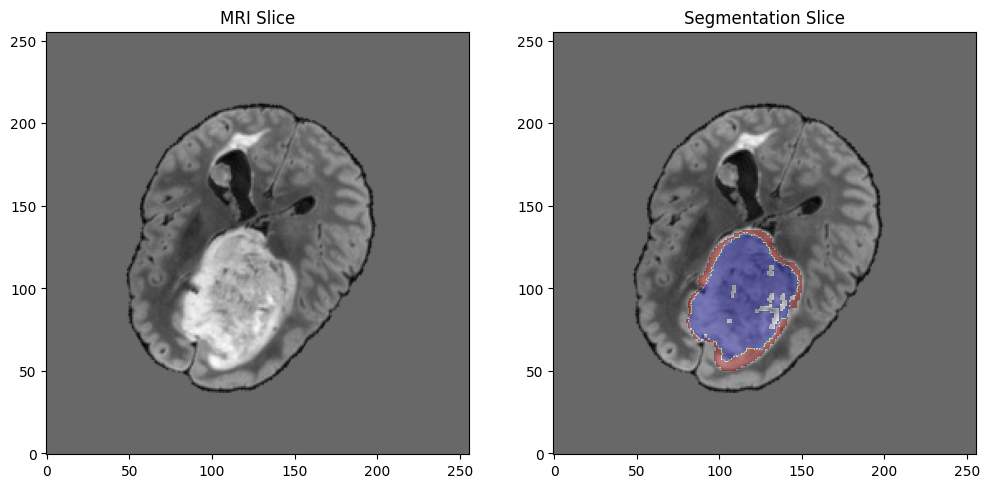

In [33]:
# Random rotation by 30 degrees works
rotate = RandRotated(keys=brats_keys, range_x=[math.radians(30), math.radians(30)], prob=1, mode =["bilinear", "nearest"])
dict = {"img": img, "seg": mask}
transformed = rotate(dict)
transformed_img, transformed_mask = transformed["img"], transformed["seg"]

img_np = img.squeeze().numpy()
mask_np = mask.squeeze().numpy()
transformed_img_np = transformed_img.squeeze().numpy()
transformed_mask_np = transformed_mask.squeeze().numpy()

#Plotting
brats_tools.plot_slices(img_np, mask_np, 'Original')
brats_tools.plot_slices(transformed_img_np, transformed_mask_np, 'Transformed')

### Testing application of transform through Dataset/inside Dataset

In [48]:
train_transform = Compose(
    [
        #EnsureChannelFirstd(brats_keys),
        #RandRotated(keys=brats_keys, range_x=[math.radians(30), math.radians(30)], prob=1, mode =["bilinear", "nearest"]),
        RandRotated(keys=brats_keys, range_x=0, range_y=0, range_z=[np.pi/4, np.pi/4], prob=1,keep_size=True, mode =["bilinear", "nearest"])
    ]
)

#train_transform = RandRotateD(keys=brats_keys, range_x=[- math.radians(30), math.radians(30)], prob=1, mode =["bilinear", "nearest"])

In [49]:
brats_path = "/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/train"
prefix = "BraTS-GLI-"
train_ds = BidsDataset(brats_path, binary = False, prefix = prefix, transform = train_transform)

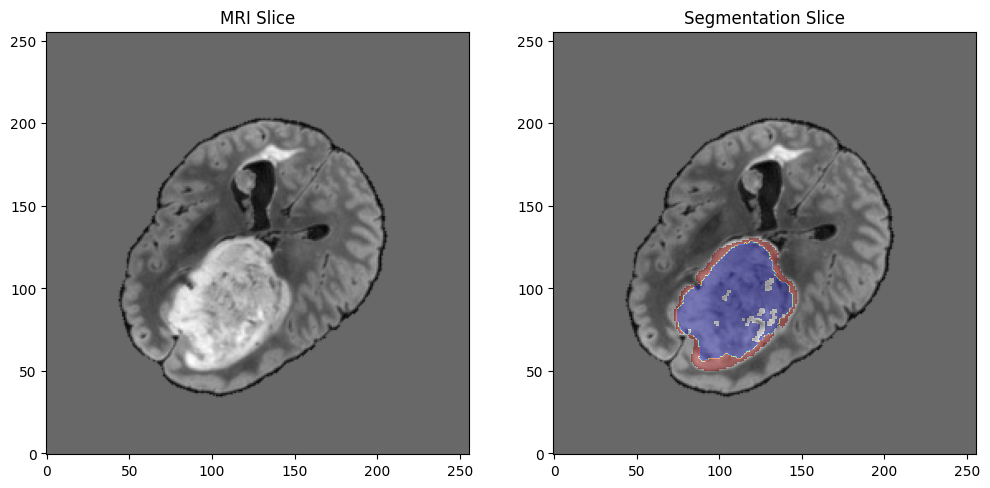

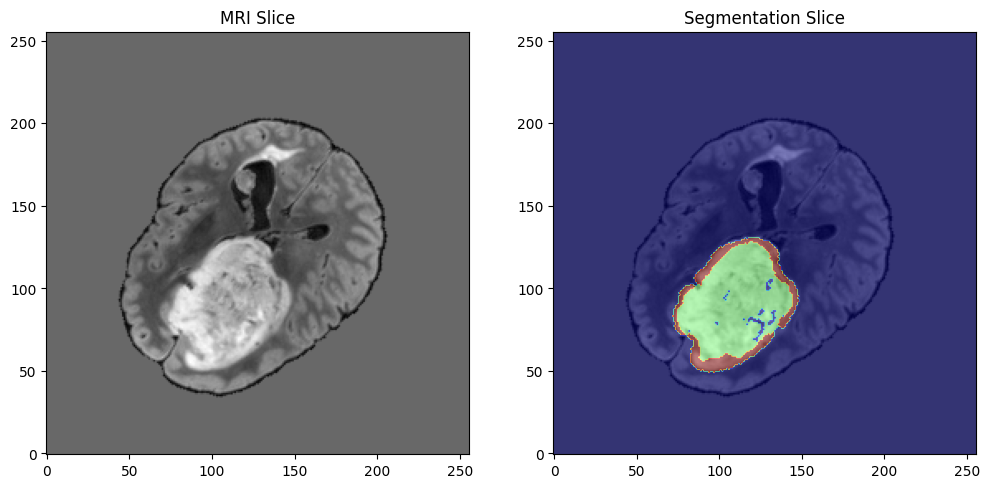

In [50]:
check_idx = 2
check_dict = train_ds[check_idx]
img, mask = check_dict['img'].squeeze().numpy(), check_dict['seg'].squeeze().numpy()
brats_tools.plot_slices(img, mask,'Check if transform inside BidsDataset works' ,omit_background=True)
brats_tools.plot_slices(img, mask,'Check if transform inside BidsDataset works' ,omit_background=False)

#### Checking how filling the holes in the seg mask would work

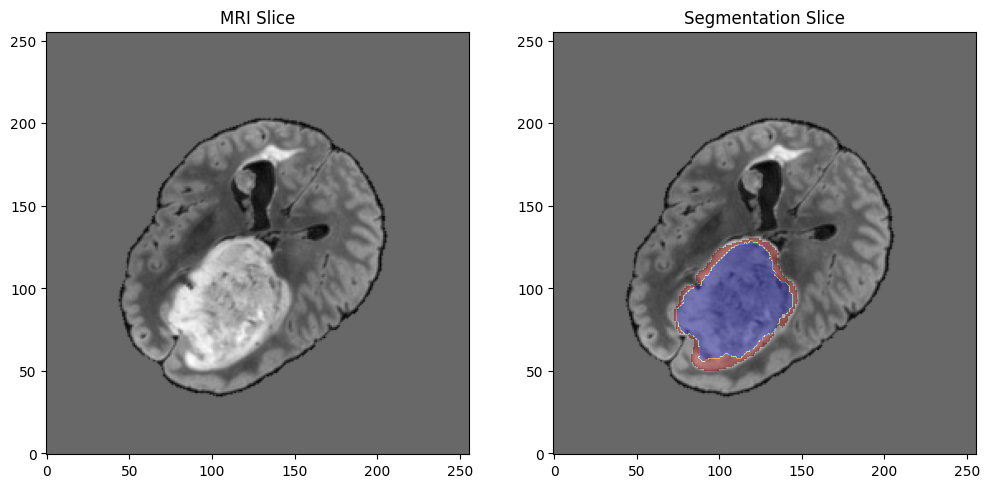

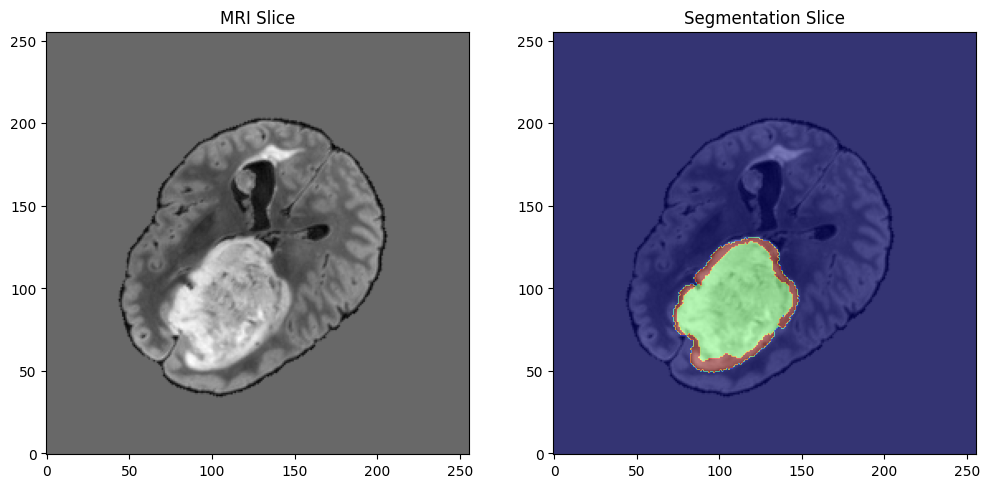

In [51]:
import TPTBox

modified_mask = TPTBox.np_utils.np_fill_holes(mask)

brats_tools.plot_slices(img, modified_mask,'Check if transform inside BidsDataset works' ,omit_background=True)
brats_tools.plot_slices(img, modified_mask,'Check if transform inside BidsDataset works' ,omit_background=False)

#### Check original img and seg for comparison if holes also exist there

In [52]:
def get_center_slice(img):
    #img is a Nifti1Image object
    data = img.get_fdata()
    center = data.shape[2] // 2     #Assuming the third dimension is the axial dimension
    return data[:, :, center]

Straight from File using TPTBox.NII.load()
nii_img.shape: (240, 240, 155), nii_mask.shape: (240, 240, 155)
nii_img.dtype: int16, nii_mask.dtype: float32
Using .get_array() method from NII object
img.shape: (240, 240, 155), mask.shape: (240, 240, 155)
img.dtype: int16, mask.dtype: uint16
img_center: 77
After slicing
nii_img_slice.dtype: int16 check_mask.dtype: uint16
check_img.dtype: int16, check_mask.dtype: uint16


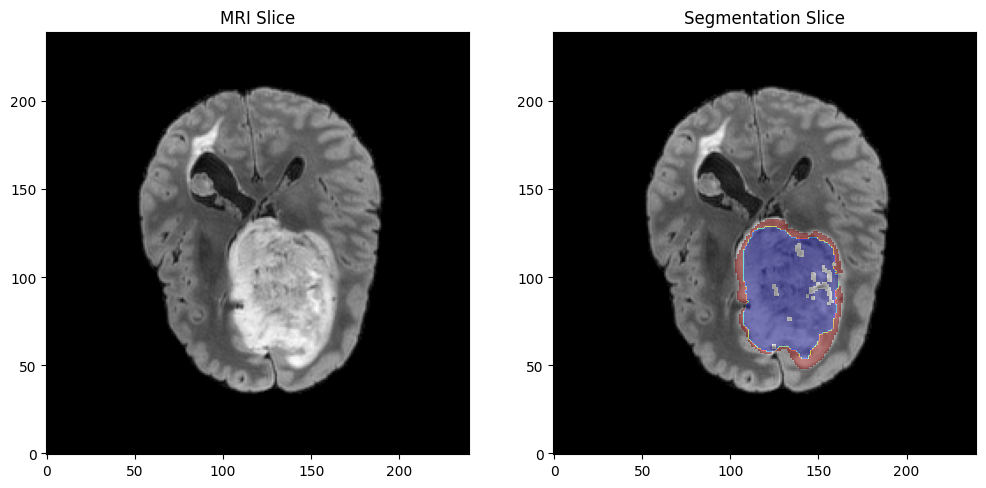

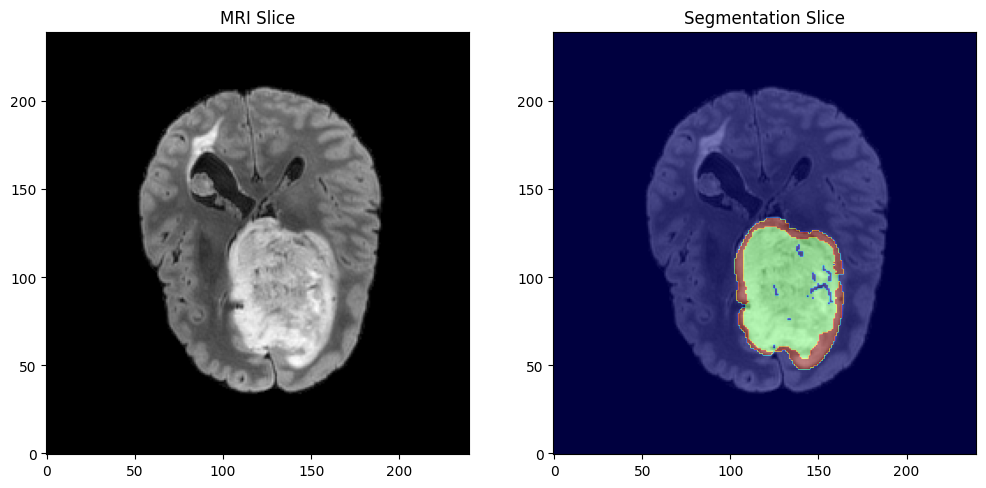

In [53]:
img_path = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/train/BraTS-GLI-00012-000/BraTS-GLI-00012-000-t2f.nii.gz'
seg_path = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/train/BraTS-GLI-00012-000/BraTS-GLI-00012-000-seg.nii.gz'

nii_img, nii_mask = NII.load(img_path, False), NII.load(seg_path, True)

print(f"Straight from File using TPTBox.NII.load()")
print(f"nii_img.shape: {nii_img.shape}, nii_mask.shape: {nii_mask.shape}")
print(f"nii_img.dtype: {nii_img.dtype}, nii_mask.dtype: {nii_mask.dtype}")

img, mask = nii_img.get_array(), nii_mask.get_array()

print(f"Using .get_array() method from NII object")
print(f"img.shape: {img.shape}, mask.shape: {mask.shape}")
print(f"img.dtype: {img.dtype}, mask.dtype: {mask.dtype}")

img_center = img.shape[2] // 2     #Assuming the third dimension is the axial dimension
print(f"img_center: {img_center}")

img_slice, mask_slice = img[:, :, img_center], mask[:, :, img_center]

print(f"After slicing")
print(f"nii_img_slice.dtype: {img_slice.dtype} check_mask.dtype: {mask_slice.dtype}")
print(f"check_img.dtype: {img.dtype}, check_mask.dtype: {mask.dtype}")

brats_tools.plot_slices(img_slice, mask_slice, 'Check original image', omit_background=True)
brats_tools.plot_slices(img_slice, mask_slice, 'Check original image', omit_background=False)

### Testing if transform works after DataModule_

In [54]:
# Added train_transforms inside DataModule which is then given to Dataset
brats_root_path = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge'
bids_dm = BidsDataModule(brats_root_path, binary = False, train_transform = train_transform, batch_size=2)


-------------------------------

Batch size: 2
imgs.shape: torch.Size([2, 1, 256, 256]), masks: torch.Size([2, 1, 256, 256])


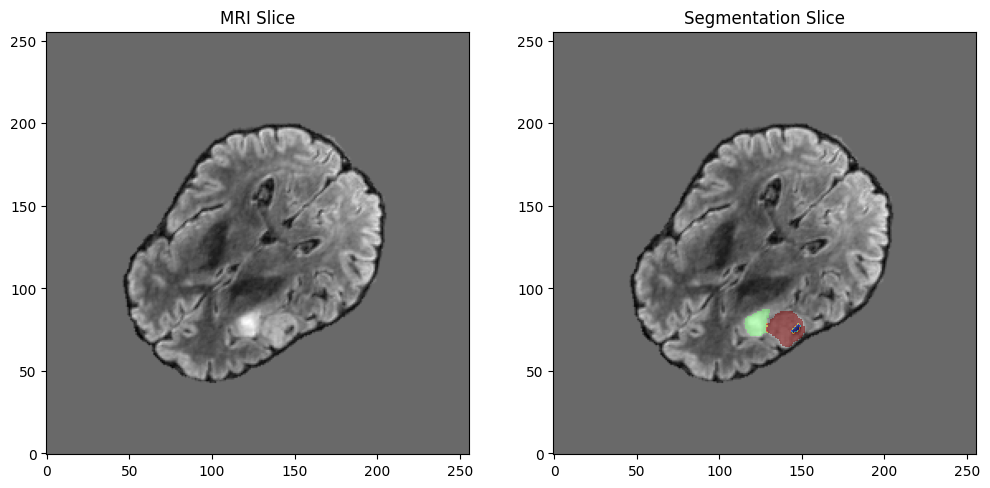

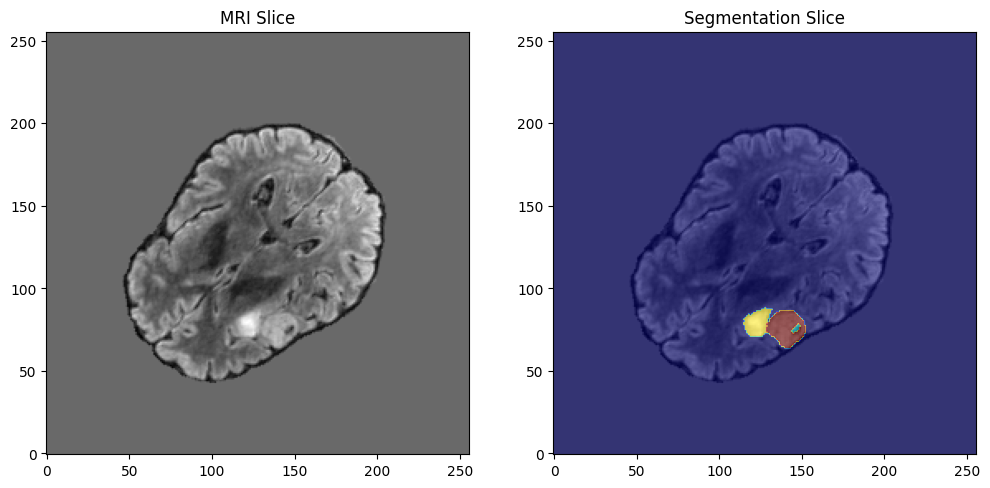

In [55]:
bids_dm.setup()
train_dl = bids_dm.train_dataloader()
sample_batch = next(iter(train_dl))
print(f"\n-------------------------------\n")
print(f"Batch size: {len(sample_batch)}")
imgs, masks = sample_batch['img'], sample_batch['seg']
print(f"imgs.shape: {imgs.shape}, masks: {masks.shape}")

test_idx = 0

sample_img = imgs[test_idx].squeeze().numpy()
sample_mask = masks[test_idx].squeeze().numpy()
brats_tools.plot_slices(sample_img, sample_mask,'Check if transform inside BidsDatamodule works' ,omit_background=True)
brats_tools.plot_slices(sample_img, sample_mask,'Check if transform inside BidsDatamodule works' ,omit_background=False)


### Testing Transformation on 3D Nifti and then slicing and processing after

#### Simulating the Data Loading that happens inside bids_dataset

Before Preprocessing
img.shape: (240, 240, 155), mask.shape: (240, 240, 155)
img.dtype: float64, mask.dtype: int64
After Preprocessing
img.shape: torch.Size([1, 240, 240, 155]), mask.shape: torch.Size([1, 240, 240, 155])
img.dtype: torch.float32, mask.dtype: torch.int64
After Rotation and Slice and Pad
img.shape: torch.Size([1, 256, 256]), mask.shape: torch.Size([1, 256, 256])


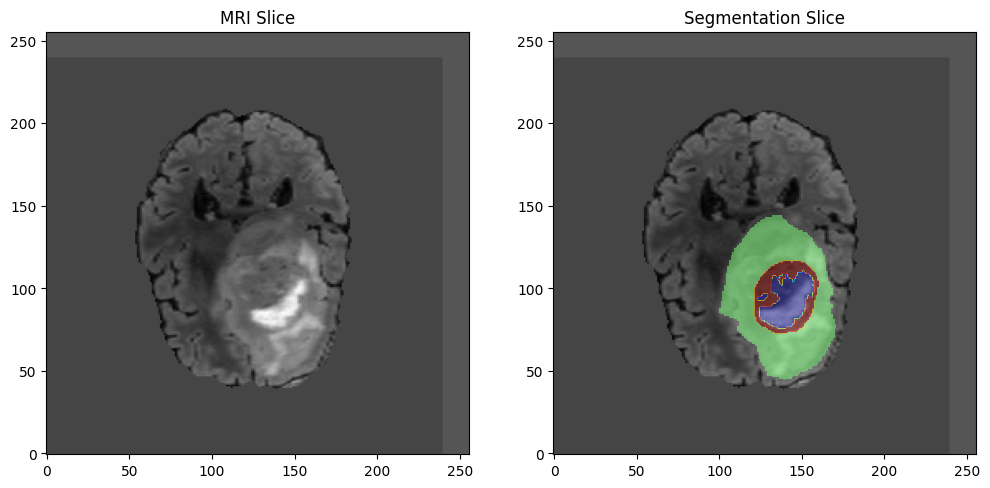

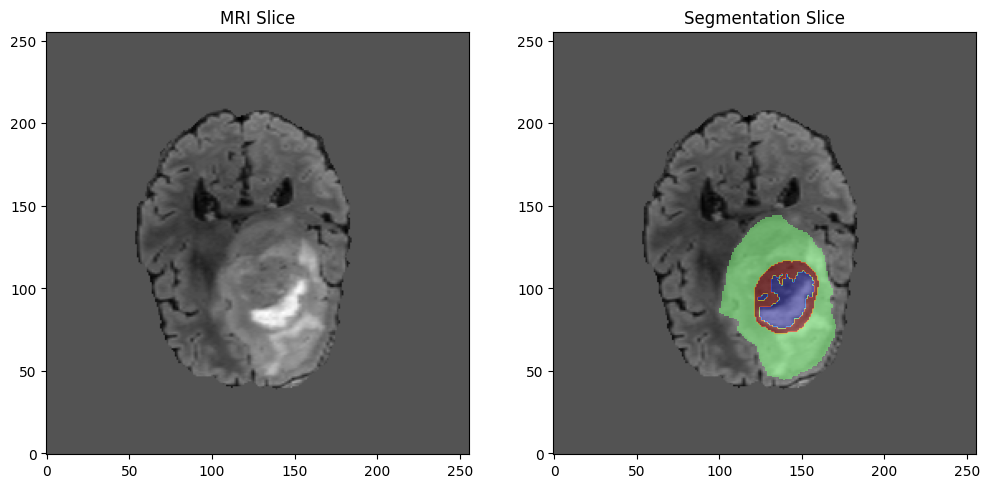

In [131]:
import monai.transforms
import monai.utils
import external.fastnumpyio.fastnumpyio as fnio
from bids_dataset import load_nifti_as_array
from utils.brats_tools import preprocess, slice_and_pad

img_path = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/train/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t2f.fnio'
mask_path = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/train/BraTS-GLI-00002-000/BraTS-GLI-00002-000-seg.fnio'
suffix = 'fnio'
do2D = True
binary = False
dict_keys = ['img', 'seg']
img_key = dict_keys[0]
seg_key = dict_keys[1]

# Rotations
angle = (0, 0, np.pi/4)

# if do2D:
#     # Rotate in 2D
#     rotate = RandRotateD(keys=brats_keys, range_x=[math.radians(30), math.radians(30)], prob=1, mode =["bilinear", "nearest"])
# else:

### TRANSFORMS ###

transforms = Compose(
    [
        RandRotated(keys=brats_keys, range_x=0, range_y=0, range_z=[-np.pi/4, np.pi/4], prob=1,keep_size=True, mode =["bilinear", "nearest"]),
        RandAffined(keys=brats_keys, prob=1, translate_range=(6, 2, 6), scale_range=(0.1, 0.1, 0.1), mode =["bilinear", "nearest"]),
        RandFlipd(keys=brats_keys, prob=1, spatial_axis=0),
    ]
)

#Random Rotation by 30 degrees on 3D image
rotate = RandRotated(keys=brats_keys, range_x=0, range_y=0, range_z=[np.pi/4, np.pi/4], prob=1,keep_size=True, mode =["bilinear", "nearest"])

#Random Flip -> spatial_axis=0 flips Left to Right, spatial_axis=1 flips Anterior to Posterior, (not visible in plot) spatial_axis=2 flips Inferior to Superior
flip = RandFlipd(keys=brats_keys, prob=1, spatial_axis=0)

#Random Affine Transformation
affine = RandAffined(keys=brats_keys, prob=1, translate_range=(6, 2, 6), scale_range=(0.1, 0.1, 0.1), mode =["bilinear", "nearest"])

#Random Elastic Transformation
elastic = Rand3DElasticd(keys=brats_keys, prob=1, sigma_range=(5, 7), magnitude_range=(50, 150), mode =["bilinear", "nearest"])

#Crop Foreground
#crop_foreground = CropForegroundd(keys=brats_keys, source_key=img_key, select_percent=0.1, margin=5, mode="symmetric")
#padding=(0,0)

#Random Contrast Adjustment
contrast = RandAdjustContrastd(keys=img_key, prob=1, gamma=(0.7,1.5))   # When padding after, the padded area is not affected by the contrast adjustment i.e. it looks different (model might not care about it though)

#Gaussian Noise
noise = RandGaussianNoised(keys=img_key, prob=1, mean=0.0, std=0.1)

### TRANSFORMS ###

if do2D:
    padding = (256, 256)
else:
    padding = (256, 256, 256)

# Load the MRI image and segmentation mask
if suffix == 'fnio':
    img = fnio.load(str(img_path))
    mask = fnio.load(str(mask_path))


# elif suffix == 'nii.gz':
#     img = load_nifti_as_array(str(img_path))
#     mask = load_nifti_as_array(str(mask_path))

mask = np.array(mask, dtype=np.int64)   # Ensure mask is integer type

print(f"Before Preprocessing")
print(f"img.shape: {img.shape}, mask.shape: {mask.shape}")
print(f"img.dtype: {img.dtype}, mask.dtype: {mask.dtype}")

img = preprocess(img, False, binary)
mask = preprocess(mask, True, binary)

print(f"After Preprocessing")
print(f"img.shape: {img.shape}, mask.shape: {mask.shape}")
print(f"img.dtype: {img.dtype}, mask.dtype: {mask.dtype}")

data_dict = {img_key: img, seg_key: mask}

#Transforms
#transformed = rotate(data_dict)
#transformed = flip(data_dict)
#transformed = affine(data_dict)
#transformed = elastic(data_dict)
#transformed = crop_foreground(data_dict)
transformed = contrast(data_dict)
#transformed = noise(data_dict)
#transformed = transforms(data_dict)
#transformed_img, transformed_mask = transformed["img"], transformed["seg"]

# Slice and Pad
if do2D:
    transformed[img_key] = slice_and_pad(transformed[img_key], padding)
    transformed[seg_key] = slice_and_pad(transformed[seg_key], padding)

    data_dict[img_key] = slice_and_pad(data_dict[img_key], padding)
    data_dict[seg_key] = slice_and_pad(data_dict[seg_key], padding)


print(f"After Rotation and Slice and Pad")
print(f"img.shape: {transformed[img_key].shape}, mask.shape: {transformed[seg_key].shape}")


brats_tools.plot_slices(transformed[img_key], transformed[seg_key], 'Transformed', omit_background=True)
brats_tools.plot_slices(data_dict[img_key], data_dict[seg_key], 'Original', omit_background=True)


#### Checking Mask Hole filling 

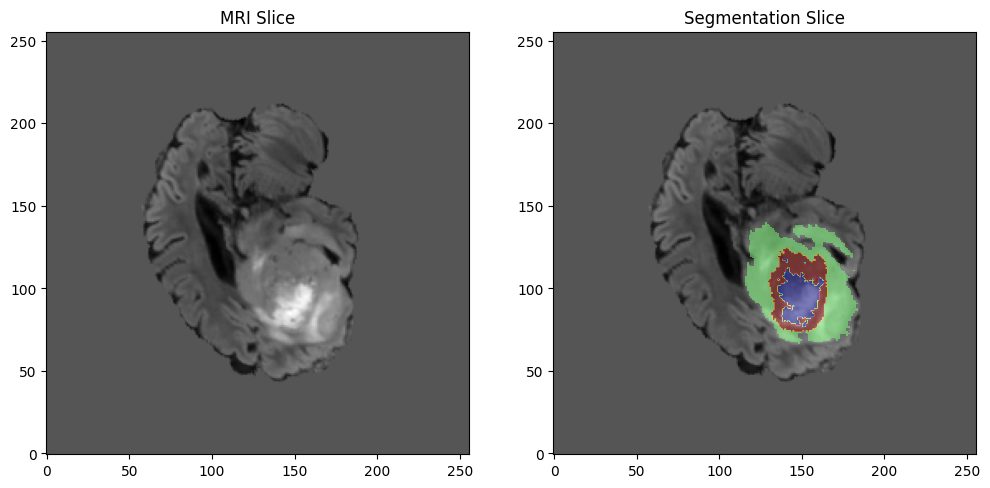

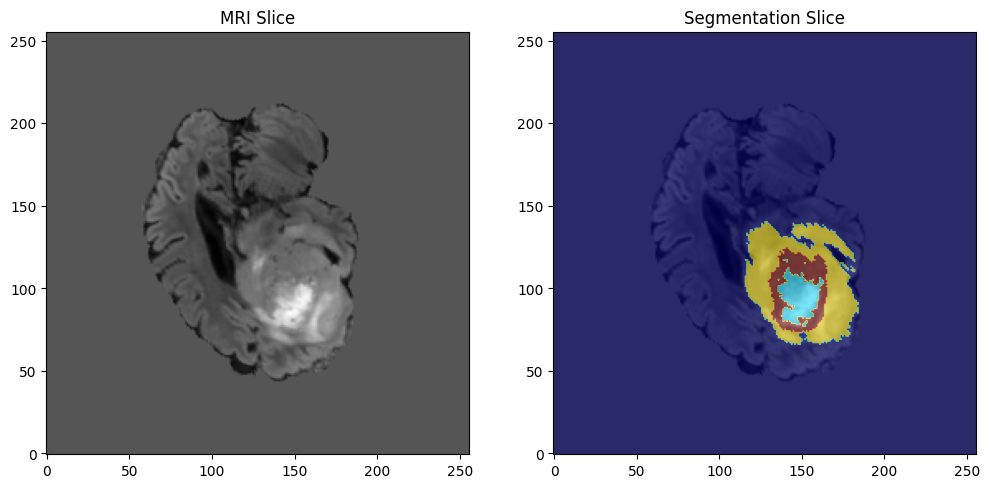

In [80]:
import TPTBox

modified_mask = TPTBox.np_utils.np_fill_holes(transformed[seg_key].squeeze().numpy())

brats_tools.plot_slices(transformed[img_key], modified_mask,'Check if transform inside BidsDataset works' ,omit_background=True)
brats_tools.plot_slices(transformed[img_key], modified_mask,'Check if transform inside BidsDataset works' ,omit_background=False)

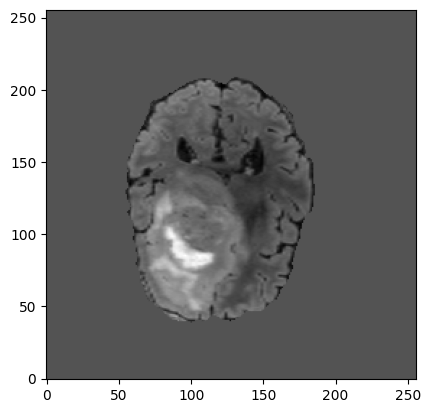

In [66]:
# plot the original and transformed images
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have an image stored in a numpy array called "image"
# You can replace "image" with your actual image array

# Plot the image
plt.imshow(transformed[img_key].T, cmap='gray', origin='lower')

# Show the plot
plt.show()

#### checking dtype of np array of nifti image before converting it to nifti

In [14]:
img_path = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/train/BraTS-GLI-00012-000/BraTS-GLI-00012-000-t2f.nii.gz'
mask_path = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/train/BraTS-GLI-00012-000/BraTS-GLI-00012-000-seg.nii.gz'

np_img = load_nifti_as_array(img_path)
np_mask = load_nifti_as_array(mask_path, True)

print(f"np_img.shape: {np_img.shape}, np_mask.shape: {np_mask.shape}")
print(f"np_img.dtype: {np_img.dtype}, np_mask.dtype: {np_mask.dtype}")

np_img.shape: (240, 240, 155), np_mask.shape: (240, 240, 155)
np_img.dtype: int16, np_mask.dtype: uint16
